In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import optuna
from lightgbm import LGBMRegressor, plot_importance
from mlforecast import MLForecast

from src.visualization.charts import ModelCharts
from src.visualization.metrics import PredictionEvaluator
from src.config import Config

/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the data

In [2]:
config = Config()
variant_co2 = 'co2'
train_df = pd.read_csv(os.path.join(config.output_cleaned_lightgbm, f'{variant_co2}/train.csv')).rename(columns={'country_index': 'country'})
test_df = pd.read_csv(os.path.join(config.output_cleaned_lightgbm, f'{variant_co2}/test.csv')).rename(columns={'country_index': 'country'})

with open(os.path.join(config.output_cleaned_lightgbm, f'{variant_co2}/data_preprocessor_lightgbm.pkl'), 'rb') as f:
    data_preprocessor_lightgbm = pickle.load(f)

In [3]:
train_df

,country_order,year,country,population_lag_1,population_lag_2,gdp_lag_1,gdp_lag_2,temperature_change_from_co2_lag_1,temperature_change_from_co2_lag_2,total_ghg_lag_1,...,coal_co2_lag_2,flaring_co2_lag_1,flaring_co2_lag_2,gas_co2_lag_1,gas_co2_lag_2,land_use_change_co2_lag_1,land_use_change_co2_lag_2,oil_co2_lag_1,oil_co2_lag_2,co2
0,0,1853,Stany Zjednoczone,0.017393,0.016985,0.010347,0.010509,0.006536,0.000000,0.115255,...,0.005568,0.000000,0.000000,0.000000,0.000000,0.351582,0.449621,0.000000,0.000000,0.142663
1,0,1854,Stany Zjednoczone,0.017965,0.017544,0.011483,0.011437,0.006536,0.006623,0.116109,...,0.006055,0.000000,0.000000,0.000000,0.000000,0.355254,0.473915,0.000000,0.000000,0.148196
2,0,1855,Stany Zjednoczone,0.018554,0.018120,0.011840,0.012690,0.013072,0.006623,0.120435,...,0.006817,0.000000,0.000000,0.000000,0.000000,0.368256,0.478863,0.000000,0.000000,0.150416
3,0,1856,Stany Zjednoczone,0.019160,0.018712,0.011940,0.013083,0.013072,0.013245,0.122052,...,0.007495,0.000000,0.000000,0.000000,0.000000,0.372171,0.496390,0.000000,0.000000,0.154770
4,0,1857,Stany Zjednoczone,0.019785,0.019322,0.012561,0.013194,0.013072,0.013245,0.125706,...,0.008625,0.000000,0.000000,0.000000,0.000000,0.382568,0.501668,0.000000,0.000000,0.156695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3148,44,1996,Szwecja,0.005071,0.005112,0.026320,0.027868,0.013072,0.013245,0.008216,...,0.002540,0.004482,0.003924,0.001754,0.001725,0.036047,0.046782,0.017440,0.017724,0.021023
3149,44,1997,Szwecja,0.005082,0.005147,0.026822,0.029056,0.013072,0.013245,0.008650,...,0.002537,0.004283,0.004482,0.001892,0.001754,0.035421,0.048590,0.018473,0.017440,0.020478
3150,44,1998,Szwecja,0.005086,0.005158,0.027630,0.029609,0.013072,0.013245,0.008228,...,0.002800,0.004762,0.004283,0.001918,0.001892,0.035754,0.047746,0.017144,0.018473,0.020634
3151,44,1999,Szwecja,0.005090,0.005162,0.028881,0.030501,0.013072,0.013245,0.008350,...,0.002437,0.004855,0.004762,0.001897,0.001918,0.036005,0.048195,0.017155,0.017144,0.019864


## Hyperparameter optimization

In [4]:
def log_mape(y_true, y_pred):
    return np.mean(np.abs((np.log1p(y_true) - np.log1p(y_pred)) / np.log1p(y_true)))

In [5]:
def objective(trial):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 15, 50),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 8, 30),
        'max_depth': trial.suggest_int('max_depth', 1, 5),
        'num_threads': trial.suggest_int('num_threads', 1, 5),
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),

        #deal with overfitting
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.8, 1.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.8, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 6.0, 10.0),

        #general params
        'verbosity': -1,
        'objective':'regression_l1',

    }

    # Initialize the LightGBM model
    model_optuna = LGBMRegressor(**param)

    # Initialize MLForecast
    forecast_model_optuna = MLForecast(
        models=[model_optuna],
        freq=1,
        date_features=None,
        num_threads=2
    )

    # Perform cross-validation manually with dynamic horizons
    all_cv_predictions = []

    for country, country_data in train_df.groupby('country'):
        horizon = max(1, int(0.15 * len(country_data)))

        # Perform cross-validation for this country
        cv_predictions = forecast_model_optuna.cross_validation(
            df=country_data.drop(columns=['country_order']),
            h=horizon,
            n_windows=2,
            step_size=horizon//2,
            id_col='country',
            time_col='year',
            target_col='co2',
            static_features=[]
        )

        cv_predictions['country'] = country
        all_cv_predictions.append(cv_predictions)

    # Concatenate all predictions into a single DataFrame
    cv_predictions = pd.concat(all_cv_predictions).reset_index(drop=True)
    cv_predictions = cv_predictions.rename(columns={'co2': 'co2_actual', 'LGBMRegressor': 'co2_predicted'})
    cv_predictions = cv_predictions.dropna(subset=['co2_actual', 'co2_predicted'])

    log_mape_value = log_mape(cv_predictions['co2_actual'], cv_predictions['co2_predicted'])

    return log_mape_value 

In [6]:
# Run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2025-01-27 12:43:43,942] A new study created in memory with name: no-name-241742d2-f0e9-47e5-b0ac-21294865074b
[I 2025-01-27 12:43:46,071] Trial 0 finished with value: 0.23301284824303917 and parameters: {'learning_rate': 0.07611017379672529, 'num_leaves': 34, 'min_data_in_leaf': 25, 'max_depth': 3, 'num_threads': 4, 'n_estimators': 74, 'bagging_fraction': 0.8812306312160242, 'feature_fraction': 0.9085344598523933, 'lambda_l1': 1.5571024811092116, 'lambda_l2': 8.687967540459564}. Best is trial 0 with value: 0.23301284824303917.
[I 2025-01-27 12:43:48,061] Trial 1 finished with value: 0.19278248920956848 and parameters: {'learning_rate': 0.08496182739322763, 'num_leaves': 19, 'min_data_in_leaf': 12, 'max_depth': 3, 'num_threads': 1, 'n_estimators': 42, 'bagging_fraction': 0.8123485792971804, 'feature_fraction': 0.972066593157225, 'lambda_l1': 8.070149693050938, 'lambda_l2': 9.425436921189888}. Best is trial 1 with value: 0.19278248920956848.
[I 2025-01-27 12:43:50,263] Trial 2 finish

Best Hyperparameters: {'learning_rate': 0.05613992927737291, 'num_leaves': 41, 'min_data_in_leaf': 11, 'max_depth': 1, 'num_threads': 5, 'n_estimators': 99, 'bagging_fraction': 0.8329399202275256, 'feature_fraction': 0.956816750611456, 'lambda_l1': 8.767455980657598, 'lambda_l2': 8.795386738726396}


## Initialize the model

In [7]:
# Initialize the model with best hyperparameters
best_model = LGBMRegressor(
    #**best_params,
    verbosity=-1,
    objective= 'regression_l1',
    metric= 'mae',
    is_unbalance= False,
)

# Initialize MLForecast with the best model
forecast_model = MLForecast(
    models=[best_model],
    freq=1,
    date_features=None,
    num_threads=2
)

## Check feature importance

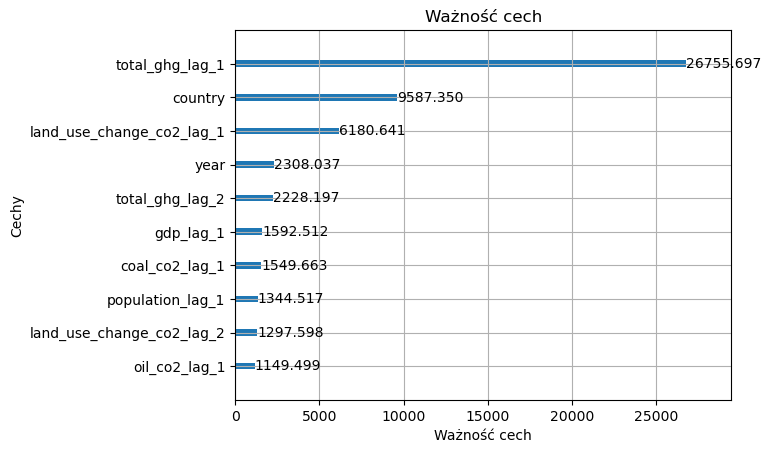

In [8]:
#Check feature importance
train_transformed = forecast_model.preprocess(
    df=train_df.drop(columns=['country_order']),
    id_col='country',
    time_col='year',
    target_col='co2',
    static_features=[]
)

X_train = train_transformed.drop(columns=['co2'])
y_train = train_transformed['co2']
X_train['country'] = X_train['country'].astype('category')

# Fit the LightGBM model
best_model.fit(X_train, y_train, categorical_feature=['country'])

# Plot feature importance
ax = plot_importance(best_model, max_num_features=10, importance_type='gain')
ax.set_title('Ważność cech')
ax.set_xlabel("Ważność cech")
ax.set_ylabel("Cechy")
plt.show()

## Fit the model

In [9]:
forecast_model.fit(
    train_df.drop(columns=['country_order']),
    id_col='country',
    time_col='year',
    target_col='co2',
    static_features=[],
    fitted=True
)

forecast_model_path = os.path.join(config.models_folder, f'{variant_co2}_lightgbm_best_model.pkl')
with open(forecast_model_path, 'wb') as f:
    pickle.dump(forecast_model, f)

## Prediction on train data

In [10]:
fitted_values = forecast_model.forecast_fitted_values()
results_train = fitted_values.rename(columns={'co2': 'co2_actual', 'LGBMRegressor': 'co2_predicted'})
results_train = results_train.dropna(subset=['co2_actual', 'co2_predicted'])

#predicted inverse transform
results_train_inverse = results_train.copy()

output_train_predicted = results_train['co2_predicted'].to_numpy().reshape(-1, 1)
inverted_data_train_predicted = data_preprocessor_lightgbm.inverse_transform_data(output_train_predicted, results_train.shape[0], train_df.shape[1]-3)
last_column_train_predicted = inverted_data_train_predicted[:, -1]
results_train_inverse['co2_predicted'] = last_column_train_predicted

output_train_actual = results_train['co2_actual'].to_numpy().reshape(-1, 1)
inverted_data_train_actual = data_preprocessor_lightgbm.inverse_transform_data(output_train_actual, results_train.shape[0], train_df.shape[1]-3)
last_column_train_actual = inverted_data_train_actual[:, -1]
results_train_inverse['co2_actual'] = last_column_train_actual

results_train_inverse.to_csv(os.path.join(config.predictions_lightgbm, f'{variant_co2}_train.csv'))

## Prediction on test data

In [11]:
all_predictions = []

for country in test_df['country'].unique():

    country_test_data = test_df[test_df['country'] == country].copy()
    horizon = country_test_data['year'].nunique()

    country_test_features = country_test_data.loc[:, country_test_data.columns != 'co2']

    country_predictions = forecast_model.predict(h=horizon, X_df=country_test_features, ids=[country])

    country_predictions['country'] = country
    country_predictions['year'] = country_test_data['year'].values[:len(country_predictions)]
    country_predictions = country_predictions.merge(
        country_test_data[['year', 'co2']],
        on='year',
        how='left'
    ).rename(columns={'co2': 'co2_actual'})

    all_predictions.append(country_predictions)

results_test = pd.concat(all_predictions).reset_index(drop=True).rename(columns={'LGBMRegressor': 'co2_predicted'})

#predicted inverse transform
results_test_inverse = results_test.copy()

output_test_predicted = results_test['co2_predicted'].to_numpy().reshape(-1, 1)
inverted_data_test_predicted = data_preprocessor_lightgbm.inverse_transform_data(output_test_predicted, results_test.shape[0], test_df.shape[1]-3)
last_column_test_predicted = inverted_data_test_predicted[:, -1]
results_test_inverse['co2_predicted'] = last_column_test_predicted

output_test_actual = results_test['co2_actual'].to_numpy().reshape(-1, 1)
inverted_data_test_actual = data_preprocessor_lightgbm.inverse_transform_data(output_test_actual, results_test.shape[0], test_df.shape[1]-3)
last_column_test_actual = inverted_data_test_actual[:, -1]
results_test_inverse['co2_actual'] = last_column_test_actual

results_test_inverse.to_csv(os.path.join(config.predictions_lightgbm, f'{variant_co2}_test.csv'))

## Charts

In [12]:
charts = ModelCharts(results_train_inverse, results_test_inverse)

#Line plot
charts.generate_line_plot(variant = variant_co2, model_output_file=config.predictions_lightgbm)
charts.generate_line_plot_one_dataset(variant = variant_co2, model_output_file=config.predictions_lightgbm, dataset_type='train')
charts.generate_line_plot_one_dataset(variant = variant_co2, model_output_file=config.predictions_lightgbm, dataset_type='test')

#Scatter plot
charts.generate_scatter_plot(variant = variant_co2, model_output_file=config.predictions_lightgbm)
charts.generate_scatter_plot_one_dataset(variant = variant_co2, model_output_file=config.predictions_lightgbm, dataset_type='train')
charts.generate_scatter_plot_one_dataset(variant = variant_co2, model_output_file=config.predictions_lightgbm, dataset_type='test')

## Metrics

In [13]:
evaluator = PredictionEvaluator()
evaluator.evaluate(results_train_inverse, results_test_inverse, actual_col='co2_actual', predicted_col='co2_predicted', variant = variant_co2, model_output_file=config.metrics_lightgbm)

## Prepare residuals to hybrid model

In [14]:
#Train data
residuals_train_df = results_train_inverse[['country', 'year']].copy()  # Include necessary columns
residuals_train_df['residual'] = results_train_inverse['co2_actual'] - results_train_inverse['co2_predicted']
residuals_train_df.to_csv(os.path.join(config.output_cleaned_hybrid, f'lightgbm_lstm/{variant_co2}/residuals_train.csv'), index=False)

In [15]:
#Test data
residuals_test_df = results_test_inverse[['country', 'year']].copy()  # Include necessary columns
residuals_test_df['residual'] = results_test_inverse['co2_actual'] - results_test_inverse['co2_predicted']
residuals_test_df.to_csv(os.path.join(config.output_cleaned_hybrid, f'lightgbm_lstm/{variant_co2}/residuals_test.csv'), index=False)